In [1]:
import numpy as np
# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../utils')

import te_mp

import scipy.integrate
import scipy.optimize
import tqdm

In [2]:
matplotlib.rcParams.update({'font.size': 6, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

# Setup

In [3]:
# Time vector for PF-CF pairings
dt_mp = 1e-3
T_mp_max = 0.2

tau = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

### Pre-calculate timer reaction equations

In [4]:
# This function evaluates the accumulate-to-threshold timer for values of phi given by the argument `rates`
def generateDiscreteTimers(tau, rates):
    single_timer_adjustment_discretization = np.zeros((len(rates), 4, len(tau)))
    for i in tqdm.notebook.trange(len(rates)):
        timer_sol = singleTimerBiochemical(rates[i], t=tau, max_step=5e-4)
        single_timer_adjustment_discretization[i,:,:] = timer_sol[:-1, :]
    return single_timer_adjustment_discretization

In [35]:
scale_rates_discretized = np.arange(0.01, 0.9, 0.005)
# Generate 
# single_timer_adjustment_discretization = generateDiscreteTimers(tau,scale_rates_discretized)
# np.save('../utils/timer_adj_discretization.npy', single_timer_adjustment_discretization)

# Load from file
single_timer_adjustment_discretization = np.load('../utils/timer_adj_discretization.npy')

To calculate how to convert between the values of $\varphi$ and $\tau_\text{peak}$, we can solve a linear regression:

In [36]:
peak_times_from_discretization = tau[np.argmax(single_timer_adjustment_discretization[:,3,:], axis=1)]

In [37]:
scale_tp = np.polyfit(scale_rates_discretized, peak_times_from_discretization, 1)
print(scale_tp)

[0.21565416 0.01052885]


In [38]:
def rate_to_tau(scale_rate):
    return scale_tp[1] + scale_tp[0]*scale_rate

def tau_to_rate(tau_peak):
    return (tau_peak - scale_tp[1])/scale_tp[0]

### Bimodal distribution

In [40]:
bimodal_distr = np.exp(-(tau-0.05)**2/(2*0.05**2)) + 2*np.exp(-(tau-0.14)**2/(2*0.01**2))
bimodal_distr /=np.sum(bimodal_distr)

# Timer adjustment

In [12]:
timer_sol_1 = te_mp.singleTimerBiochemical(tau_to_rate(0.12), t=tau, max_step=5e-4)
timer_sol_2 = te_mp.singleTimerBiochemical(tau_to_rate(0.14), t=tau, max_step=5e-4)

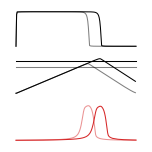

In [27]:
plt.figure(figsize=(1.5,1.5))

plt.subplot(3,1,1)
plt.plot(tau, timer_sol_1[0,:], c='k', alpha=0.5,lw=0.75)
plt.plot(tau, timer_sol_2[0,:], c='k',lw=0.75)
plt.axis('off')
plt.subplot(3,1,2)
plt.plot(tau, timer_sol_1[2,:], c='k', alpha=0.5,lw=0.75)
plt.plot(tau, timer_sol_2[2,:], c='k',lw=0.75)
plt.plot([0, 0.2], [0.5,]*2, c='k',alpha=0.5,lw=0.75)
plt.plot([0, 0.2], [0.6,]*2, c='k',lw=0.75)
plt.axis('off')
plt.subplot(3,1,3)
plt.plot(tau, timer_sol_1[3,:], c='C3', alpha=0.5,lw=0.75)
plt.plot(tau, timer_sol_2[3,:], c='C3',lw=0.75)
plt.axis('off')

plt.tight_layout()
# plt.savefig('figures/biochemical-timer-adjustment-shift.pdf')

## Narrow temp window

Load results from simulation (found in `scripts/timer-adjustment-biochemical-narrow.py`). In this simulation, we discretized the parameter defining when peak eligibility occurs ($\varphi$) into steps of 0.005 units. The solution to the reaction equations is found in the variable `single_timer_adjustment_discretization`.

In [31]:
# Load the results of running the experiment script
rates_history = np.loadtxt('timer-adjustment-biochem-narrow-results.csv', delimiter=',')
rates_mean = np.mean(rates_history, axis=0)

In [32]:
# Take the average value of \phi over the last 100 samples, and round to nearest discretized value
scale_rate_final_discretized = np.digitize(np.mean(rates_mean[-100:]), scale_rates_discretized)-1

### Figure 5I, top — final eligibility window

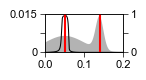

In [129]:
plt.figure(figsize=(1,0.5))

ax = plt.gca()

ax2 = plt.twinx()
ax.fill_between(tau, bimodal_distr, facecolor=(0.7,)*3)
ax.set_yticks([0,0.0075,0.015],[0,'',0.015])
ax.set_ylim([0, 0.015])
ax.set_xlim([0, 0.2])

timer_max = single_timer_adjustment_discretization[scale_rate_final_discretized,3,:]
ax2.plot(tau, timer_max,c='k',lw=0.75,clip_on=False)
ax2.plot([0.05,]*2, [0,1],'r')
ax2.plot([0.14,]*2, [0,1],'r')
ax2.set_yticks([0,0.5,1],[0,'',1])
ax2.set_ylim([0,1])
# plt.savefig('figures/biochemical-timer-adjustment/bimodal-peak-biochem-acc.pdf')

### Figure 5I, bottom — dynamics

Calculate the expected change in $\tau_\text{peak}$ for each $\tau_\text{peak}$:

In [41]:
delta_scale_rate_discretized = np.zeros(len(scale_rates_discretized))

for i in range(len(scale_rates_discretized)):
    timer_ = single_timer_adjustment_discretization[i,:,:]
    # timer_[3,:] /= np.max(timer_[3,:])
    narrow_window = te_mp.TeMP_rule_singleTimer(tau, tau, timer_, True, right_scale=1/0.8)
    delta_scale_rate_discretized[i] = np.sum(narrow_window*bimodal_distr)

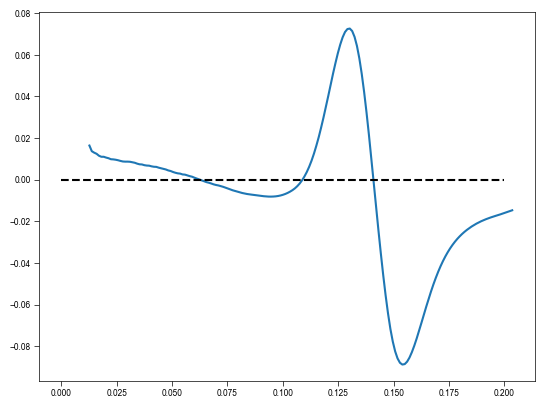

In [42]:
plt.plot(rate_to_tau(scale_rates_discretized), delta_scale_rate_discretized)
plt.plot([0,0.2],[0,0],'k--')

In [65]:
iters = np.arange(peak_times_test.shape[1])*100

In [116]:
tp_phase = np.linspace(scale_rates_discretized[-1]*0.05, scale_rates_discretized[-1]*0.9, 8) # 8
tt_phase = np.linspace(len(iters)*100*0.15, len(iters)*100*0.85, 4)

tpp, ttt = np.meshgrid(tp_phase, tt_phase)

In [117]:
dtpp = np.interp(tpp, scale_rates_discretized,  delta_scale_rate_discretized,)
dttt = np.ones(ttt.shape)

dtpp_norm = dtpp/np.sqrt(dtpp**2 + dttt**2)
dttt_norm = dttt/np.sqrt(dtpp**2 + dttt**2)

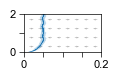

In [121]:
plt.figure(figsize=(1,0.5))
plt.quiver(rate_to_tau(tpp), ttt, dtpp_norm, dttt_norm, angles='xy', pivot='middle', color=(0.7,)*3)

plt.fill_betweenx(iters, peak_times_mean-peak_times_std, peak_times_mean+peak_times_std,alpha=0.3)
plt.plot( peak_times_mean, iters,lw=0.5)
plt.ylim([0,2e5])
plt.yticks([0,1e5,2e5],[0,'',2])
plt.xticks(np.linspace(0,0.2,5),[0,'','','',0.2]);
# plt.savefig('figures/biochemical-timer-adjustment/bimodal-peak-biochem-acc-dynamics.pdf')

### Figure 5D2 — biochemical TeMP rule

In [182]:
timer_ind = np.digitize((0.12- sol[1])/sol[0], scale_rates_discretized) - 1
temp_rule = te_mp.TeMP_rule_singleTimer(tau, tau, single_timer_adjustment_discretization[timer_ind,:],
                                       True,left_scale=0.8)

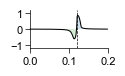

In [193]:
plt.figure(figsize=(1,0.5))
plt.fill_between(tau,  np.minimum(temp_rule, 0), 0, facecolor='C2',alpha=0.2)
plt.fill_between(tau, 0, np.maximum(temp_rule, 0), facecolor='C0',alpha=0.2)
plt.plot(tau, temp_rule,clip_on=False,c='k',lw=0.75)
plt.plot([0.12,]*2, [-1.2,1.2], 'k--',lw=0.5)
plt.xlim([0,0.2])
plt.ylim([-1.2,1.2])
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('figures/biochemical-timer-adjustment/narrow-window.pdf')

## Broad TeMP window

Load results from simulation (found in `scripts/timer-adjustment-biochemical-broad.py`).

In [45]:
rates_history = np.loadtxt('timer-adjustment-biochem-broad-results.csv',delimiter=',')
rates_mean = np.mean(rates_history, axis=0)

In [46]:
scale_rate_final_discretized = np.digitize(np.mean(rates_mean[-100:]), scale_rates_discretized)-1

### Figure 5H — final eligibility window

(0.0, 1.0)

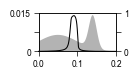

In [47]:
plt.figure(figsize=(1,0.5))

ax = plt.gca()

ax2 = plt.twinx()
ax.fill_between(tau, bimodal_distr, facecolor=(0.7,)*3)
ax.set_yticks([0,0.0075,0.015],[0,'',0.015])
ax.set_ylim([0, 0.015])
ax.set_xlim([0, 0.2])

timer_max = single_timer_adjustment_discretization[scale_rate_final_discretized,3,:]
ax2.plot(tau, timer_max,c='k',lw=0.75,clip_on=False)

ax2.set_yticks([0,0.5,1],[0,'',1])
ax2.set_ylim([0,1])
# plt.savefig('figures/biochemical-timer-adjustment/bimodal-peak-biochem-acc-broad.pdf')

### Cumulative distribution showing median

In [18]:
distr_median = np.interp(0.5, np.cumsum(bimodal_distr), tau)

In [19]:
distr_median

np.float64(0.08767721534791648)

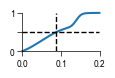

In [21]:
plt.figure(figsize=(1,0.5))
plt.plot(tau, np.cumsum(bimodal_distr), clip_on=False)
plt.plot([distr_median,]*2, [0,1], 'k--',lw=1)
plt.plot([tau[0],tau[-1]], [0.5,]*2, 'k--',lw=1)

ax= plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([0,1])
plt.xlim([0,0.2])

plt.yticks([0,0.5,1],[0,'',1]);
# plt.savefig('figures/biochemical-timer-adjustment/bimodal-median-biochem-acc-broad.pdf')

### Figure 5H — biochemical TeMP rule

In [176]:
timer_ind = np.digitize((0.12- sol[1])/sol[0], scale_rates_discretized) - 1
temp_rule = te_mp.TeMP_rule_singleTimer(tau, tau, single_timer_adjustment_discretization[timer_ind,:],
                                       False)

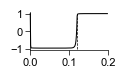

In [180]:
plt.figure(figsize=(1,0.5))
plt.plot(tau, temp_rule,clip_on=False,c='k',lw=0.75)
plt.plot([0.12,]*2, [-1,1], 'k--',lw=0.5)
plt.xlim([0,0.2])
plt.ylim([-1.1,1.1])
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig('figures/biochemical-timer-adjustment/broad-window.pdf')

# Timer selection

## Example dynamics

In [65]:
example_timer_rates = [0.01, 0.1, 0.78]
timers_biochemical = np.zeros((4, len(tau), len(example_timer_rates)))
for i in tqdm.notebook.trange(len(example_timer_rates)):
    timers_biochemical[:,:,i] = te_mp.singleTimerBiochemical(example_timer_rates[i], t=tau, max_step=5e-4)

  0%|          | 0/3 [00:00<?, ?it/s]

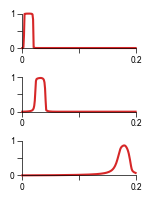

In [67]:
plt.figure(figsize=(1.5,2))
for i in range(len(example_timer_rates)):
    ax = plt.subplot(3,1,i+1)
    plt.plot(tau, timers_biochemical[3,:,i], clip_on=False, c='C3')
    plt.xlim([0, 0.2])
    plt.ylim([0, 1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xticks([0, 0.1, 0.2],[0,'',0.2])
    plt.yticks([0,0.5,1],[0,'',1])
plt.tight_layout()
# plt.savefig('multiple-timer-biochemical-basis.pdf')

## Fixed updates — 11 timers

Load results from the simulation (found in `scripts/timer-selection-biochemical-accumulator-fixed.py`).

In [53]:
## Choose a set of 11 timers that tiles the 200 ms range
timer_bank = np.copy(single_timer_adjustment_discretization[::17, 3, :])

In [51]:
# Load results from the script
v_final = np.loadtxt('timer-selection-biochem-fixed-results.csv', delimiter=',')

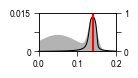

In [55]:
plt.figure(figsize=(1,0.5))

ax = plt.gca()

ax2 = plt.twinx()
ax.fill_between(tau, bimodal_distr, facecolor=(0.7,)*3)
ax.set_yticks([0,0.0075,0.015],[0,'',0.015])
ax.set_ylim([0, 0.015])
ax.set_xlim([0, 0.2])

ax2.plot(tau, v_final@timer_bank,c='k',lw=0.75,clip_on=False)
ax2.plot([0.14,]*2, [0,1],'r') # Highlight true peak of distribution
ax2.set_yticks([0,0.5,1],[0,'',1])
ax2.set_ylim([0,1]);

# plt.savefig('figures/biochemical-timer-selection/bimodal-biochem-acc.pdf')

## Proportional updates — 22 timers
Load results from simulation (found in `scripts/timer-selection-biochemical-accumulator.proportional.py`)

In [56]:
inds_ = np.digitize(np.linspace(0.01,0.9,22), scale_rates_discretized) -1
biochem_timer_bank = np.copy(single_timer_adjustment_discretization[inds_, 3, :])
    

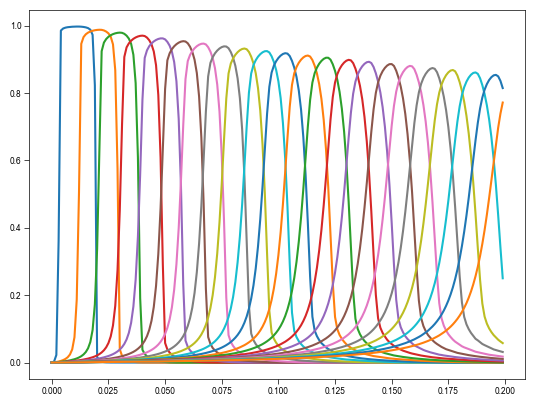

In [57]:
# Plot timer bank:
for i in range(biochem_timer_bank.shape[0]):
    plt.plot(tau, biochem_timer_bank[i,:])

In [61]:
# Load results of simulation
v_history = np.loadtxt('timer-selection-biochem-prop-results.csv',delimiter=',')

In [62]:
eligibility_window_mean = np.mean(biochem_timer_bank.T@v_history,axis=1)

### Figure 5K

(0.0, 0.3)

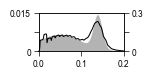

In [63]:
plt.figure(figsize=(1.1,0.5))

ax = plt.gca()

ax2 = plt.twinx()
ax.fill_between(tau, bimodal_distr, facecolor=(0.7,)*3)
ax.set_yticks([0,0.0075,0.015],[0,'',0.015])
ax.set_ylim([0, 0.015])
ax.set_xlim([0, 0.2])

ax2.plot(tau, eligibility_window_mean,c='k',lw=0.75,clip_on=False)

y_max = 0.3
ax2.set_yticks([0,y_max/2,y_max],[0,'',y_max])
ax2.set_ylim([0,y_max])

# plt.savefig('figures/biochemical-timer-selection/bimodal-biochem-acc-prop.pdf')